In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC

In [148]:
pd.set_option('display.max_rows', 10)

In [150]:
df = pd.read_csv('DNN-EdgeIIoT-dataset.csv', low_memory=False) #load dataset

In [151]:
df['Attack_type'].unique() #view unique attack types

array(['Normal', 'MITM', 'Uploading', 'Ransomware', 'SQL_injection',
       'DDoS_HTTP', 'DDoS_TCP', 'Password', 'Port_Scanning',
       'Vulnerability_scanner', 'Backdoor', 'XSS', 'Fingerprinting',
       'DDoS_UDP', 'DDoS_ICMP'], dtype=object)

In [152]:
print(df.shape)

(2219201, 63)


Select only Ransomware attack traffic and Normal traffic

In [157]:
ransomware_df = df[df['Attack_type'].isin(['Ransomware', 'Normal'])] # keeping only RansomWare and normal traffic
print(len(ransomware_df))

1626568


In [159]:
ransomware_df[:10]

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,2021 11:44:10.081753000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,2021 11:44:10.162218000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,2021 11:44:10.162271000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,2021 11:44:10.162641000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,2021 11:44:10.166132000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal
5,2021 11:44:10.166159000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
6,2021 11:44:10.166968000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
7,2021 11:44:10.167072000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
8,2021 11:44:10.169612000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
9,2021 11:44:10.169644000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal


### Remove duplicate rows

In [162]:
print("Count of Normal traffic: " + str(len(ransomware_df[ransomware_df['Attack_label'] == 0])))
print("Count of Ransomware traffic: " + str(len(ransomware_df[ransomware_df['Attack_label'] == 1])))
removed_duplicate_df = ransomware_df.drop_duplicates()
print("Count of dropped Normal traffic: " + str(len(removed_duplicate_df[removed_duplicate_df['Attack_label'] == 0])))
print("Count of dropped Ransomware traffic: " + str(len(removed_duplicate_df[removed_duplicate_df['Attack_label'] == 1])))

Count of Normal traffic: 1615643
Count of Ransomware traffic: 10925
Count of dropped Normal traffic: 1615643
Count of dropped Ransomware traffic: 10925


In [164]:
ransomware_df = removed_duplicate_df

### UnderSample Data in format 1:2 Attack vs Normal traffic

In [168]:
def print_traffic_proportion_pie(df, title):
    plt.figure(figsize=(5, 5))
    plt.pie(
        x = df['Attack_label'].value_counts(),
        labels = ['Normal', 'Ransomware'],
        autopct = lambda p: '{:.0f}'.format(p * len(df) / 100),
    )
    plt.title(title)
    plt.show() 

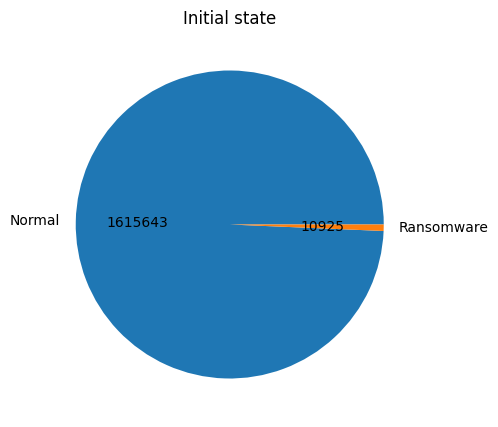

In [170]:
print_traffic_proportion_pie(ransomware_df, "Initial state")

In [172]:
#undersample the Normal datasets

x = ransomware_df.drop(columns='Attack_label')  # Features
y = ransomware_df['Attack_label']  # Target
len_attack = len(ransomware_df[ransomware_df['Attack_label'] == 1])

rus = RandomUnderSampler(sampling_strategy={0: len_attack * 2}, random_state=42)

x_resampled, y_resampled = rus.fit_resample(x, y)

# Combine back into a DataFrame
df_undersampled = pd.concat([x_resampled, y_resampled], axis=1)

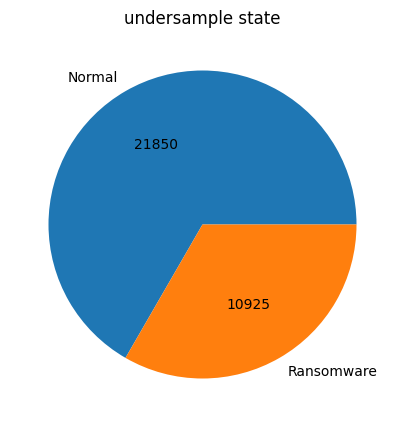

In [174]:
print_traffic_proportion_pie(df_undersampled, "undersample state")

# Clean up columns

In [177]:
print(len(df_undersampled.columns))
df_undersampled = df_undersampled.drop(columns = 'frame.time') # datetime of attack
df_undersampled = df_undersampled.drop(columns = 'Attack_type') # already stored in attack_label [0 - Normal, 1 -Attack]
print(len(df_undersampled.columns))

63
61


In [179]:
# remove columns with zero value data
print(len(df_undersampled.columns))
columns = df_undersampled.columns
for col in columns:
    ucnt = df_undersampled[col].nunique()
    if ucnt == 1:
        print(f"for column {col} there is 1 unique value of type {df_undersampled[col].value_counts()}")
        df_undersampled = df_undersampled.drop(columns = col)

print(f"Current count of columns: {len(df_undersampled.columns)}")

61
for column icmp.checksum there is 1 unique value of type icmp.checksum
0.0    32775
Name: count, dtype: int64
for column icmp.seq_le there is 1 unique value of type icmp.seq_le
0.0    32775
Name: count, dtype: int64
for column icmp.transmit_timestamp there is 1 unique value of type icmp.transmit_timestamp
0.0    32775
Name: count, dtype: int64
for column icmp.unused there is 1 unique value of type icmp.unused
0.0    32775
Name: count, dtype: int64
for column http.file_data there is 1 unique value of type http.file_data
0.0    32775
Name: count, dtype: int64
for column http.content_length there is 1 unique value of type http.content_length
0.0    32775
Name: count, dtype: int64
for column http.request.uri.query there is 1 unique value of type http.request.uri.query
0.0    32775
Name: count, dtype: int64
for column http.request.method there is 1 unique value of type http.request.method
0.0    32775
Name: count, dtype: int64
for column http.referer there is 1 unique value of type http.

### Convert Object to Numeric type

In [182]:
df_undersampled.dtypes

ip.src_host            object
ip.dst_host            object
arp.dst.proto_ipv4     object
arp.opcode            float64
arp.hw.size           float64
                       ...   
mqtt.ver              float64
mbtcp.len             float64
mbtcp.trans_id        float64
mbtcp.unit_id         float64
Attack_label            int64
Length: 44, dtype: object

In [184]:
# 12 non-Numeric types

In [186]:
def print_val_cnt(column_name):
    print(df_undersampled[column_name].value_counts())    
    print(df_undersampled[column_name].dtypes)

In [188]:
# convert hex columns
print_val_cnt('mqtt.conack.flags')
df_undersampled['mqtt.conack.flags'] = df_undersampled['mqtt.conack.flags'].apply(lambda x: 0 if (x == '0x00000000') else float(x))
print_val_cnt('mqtt.conack.flags')

mqtt.conack.flags
0             20769
0.0           10925
0x00000000     1081
Name: count, dtype: int64
object
mqtt.conack.flags
0.0    32775
Name: count, dtype: int64
float64


In [190]:
print(df_undersampled['tcp.srcport'].dtypes)
df_undersampled['tcp.srcport'] = df_undersampled['tcp.srcport'].apply(lambda x: float(x))
print(df_undersampled['tcp.srcport'].dtypes)

object
float64


In [192]:
# encoding mqtt.protoname and mqtt.topic
print_val_cnt('mqtt.protoname')
print("---------------------")
print_val_cnt('mqtt.topic')

mqtt.protoname
0       20743
0.0     10925
MQTT     1107
Name: count, dtype: int64
object
---------------------
mqtt.topic
0                           20723
0.0                         10925
Temperature_and_Humidity     1127
Name: count, dtype: int64
object


In [194]:
df_undersampled['mqtt.protoname'] = df_undersampled['mqtt.protoname'].apply(lambda x: 1 if (x == 'MQTT') else float(x))
df_undersampled['mqtt.topic'] = df_undersampled['mqtt.topic'].apply(lambda x: 1 if (x == 'Temperature_and_Humidity') else float(x))

print_val_cnt('mqtt.protoname')
print("---------------------")
print_val_cnt('mqtt.topic')

mqtt.protoname
0.0    31668
1.0     1107
Name: count, dtype: int64
float64
---------------------
mqtt.topic
0.0    31648
1.0     1127
Name: count, dtype: int64
float64


In [196]:
# encode the rest of the data

In [198]:
print_val_cnt('ip.src_host')
print("----------------------------------")
print_val_cnt('ip.dst_host')
print("----------------------------------")
print_val_cnt('arp.dst.proto_ipv4')
print("----------------------------------")
print_val_cnt('arp.src.proto_ipv4')

ip.src_host
192.168.0.128      14061
192.168.0.101       8963
0                   4874
192.168.0.170       4796
0.0.0.0               73
192.168.0.1            7
160.119.193.252        1
Name: count, dtype: int64
object
----------------------------------
ip.dst_host
192.168.0.128      13767
192.168.0.101       9013
192.168.0.170       4892
0                   4874
224.0.0.251           75
224.0.0.1             73
224.0.0.252           65
192.168.0.1           14
143.107.229.210        2
Name: count, dtype: int64
object
----------------------------------
arp.dst.proto_ipv4
0                32225
192.168.0.128      256
192.168.0.170      225
192.168.0.147       31
192.168.0.1         28
192.168.0.129        6
192.168.0.101        4
Name: count, dtype: int64
object
----------------------------------
arp.src.proto_ipv4
0                32225
192.168.0.128      255
192.168.0.170      225
192.168.0.1         66
192.168.0.101        4
Name: count, dtype: int64
object


In [200]:
# clean up dns names to encode with the rest
print_val_cnt('dns.qry.name.len')
df_undersampled['dns.qry.name.len'] = df_undersampled['dns.qry.name.len'].apply(lambda x: '0' if (x == '0.0') else x)
print_val_cnt('dns.qry.name.len')

dns.qry.name.len
0                        21829
0.0                      10925
2.debian.pool.ntp.org        8
0.debian.pool.ntp.org        6
1.debian.pool.ntp.org        5
3.debian.pool.ntp.org        2
Name: count, dtype: int64
object
dns.qry.name.len
0                        32754
2.debian.pool.ntp.org        8
0.debian.pool.ntp.org        6
1.debian.pool.ntp.org        5
3.debian.pool.ntp.org        2
Name: count, dtype: int64
object


In [202]:
ordinal_encoder = OrdinalEncoder()

In [204]:
to_encode = df_undersampled[['ip.src_host','ip.dst_host','arp.dst.proto_ipv4', 'arp.src.proto_ipv4', 'dns.qry.name.len']]
df_undersampled[[
    'ip.src_host',
    'ip.dst_host',
    'arp.dst.proto_ipv4',
    'arp.src.proto_ipv4',
    'dns.qry.name.len']] = ordinal_encoder.fit_transform(to_encode)
df_undersampled[:10]

,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,tcp.ack,tcp.ack_raw,tcp.checksum,tcp.connection.fin,...,mqtt.msgtype,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label
391801,5.0,3.0,0.0,0.0,0.0,0.0,59.0,3.597022e+09,57554.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
888507,5.0,3.0,0.0,0.0,0.0,0.0,15.0,2.915674e+09,62091.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
40387,4.0,4.0,0.0,0.0,0.0,0.0,6.0,3.393641e+08,47203.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
848690,5.0,3.0,0.0,0.0,0.0,0.0,59.0,2.449212e+09,58258.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
463515,5.0,3.0,0.0,0.0,0.0,0.0,56.0,2.392046e+08,35939.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
759159,5.0,3.0,0.0,0.0,0.0,0.0,59.0,3.160509e+09,33287.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
255775,5.0,3.0,0.0,0.0,0.0,0.0,59.0,1.500417e+09,2225.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
801878,4.0,4.0,0.0,0.0,0.0,0.0,6.0,2.564171e+09,10158.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
773783,5.0,3.0,0.0,0.0,0.0,0.0,59.0,2.470549e+09,47487.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
119572,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,62540.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [206]:
ordinal_encoder.categories_

[array(['0', '0.0.0.0', '160.119.193.252', '192.168.0.1', '192.168.0.101',
        '192.168.0.128', '192.168.0.170'], dtype=object),
 array(['0', '143.107.229.210', '192.168.0.1', '192.168.0.101',
        '192.168.0.128', '192.168.0.170', '224.0.0.1', '224.0.0.251',
        '224.0.0.252'], dtype=object),
 array(['0', '192.168.0.1', '192.168.0.101', '192.168.0.128',
        '192.168.0.129', '192.168.0.147', '192.168.0.170'], dtype=object),
 array(['0', '192.168.0.1', '192.168.0.101', '192.168.0.128',
        '192.168.0.170'], dtype=object),
 array(['0', '0.debian.pool.ntp.org', '1.debian.pool.ntp.org',
        '2.debian.pool.ntp.org', '3.debian.pool.ntp.org'], dtype=object)]

In [208]:
df_undersampled.dtypes

ip.src_host           float64
ip.dst_host           float64
arp.dst.proto_ipv4    float64
arp.opcode            float64
arp.hw.size           float64
                       ...   
mqtt.ver              float64
mbtcp.len             float64
mbtcp.trans_id        float64
mbtcp.unit_id         float64
Attack_label            int64
Length: 44, dtype: object

In [210]:
# only objects left are mqtt.msg, tcp.options and tpc.payload which is a series of bytes which will be dropped,
#alternatively they can be split and converted in ints 
df_undersampled = df_undersampled.drop(columns = ['mqtt.msg', 'tcp.payload', 'tcp.options'])

### Remove outliers

<Axes: xlabel='tcp.flags', ylabel='mqtt.len'>

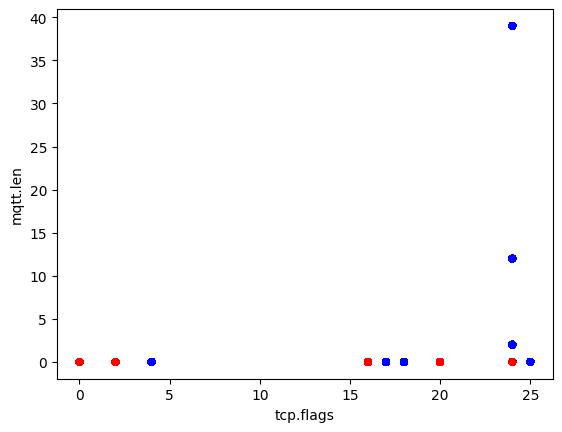

In [213]:
color_map = {0: 'blue', 1: 'red'}
colors = df_undersampled['Attack_label'].map(color_map)
df_undersampled.plot.scatter( x="tcp.flags", y="mqtt.len" , c=colors)

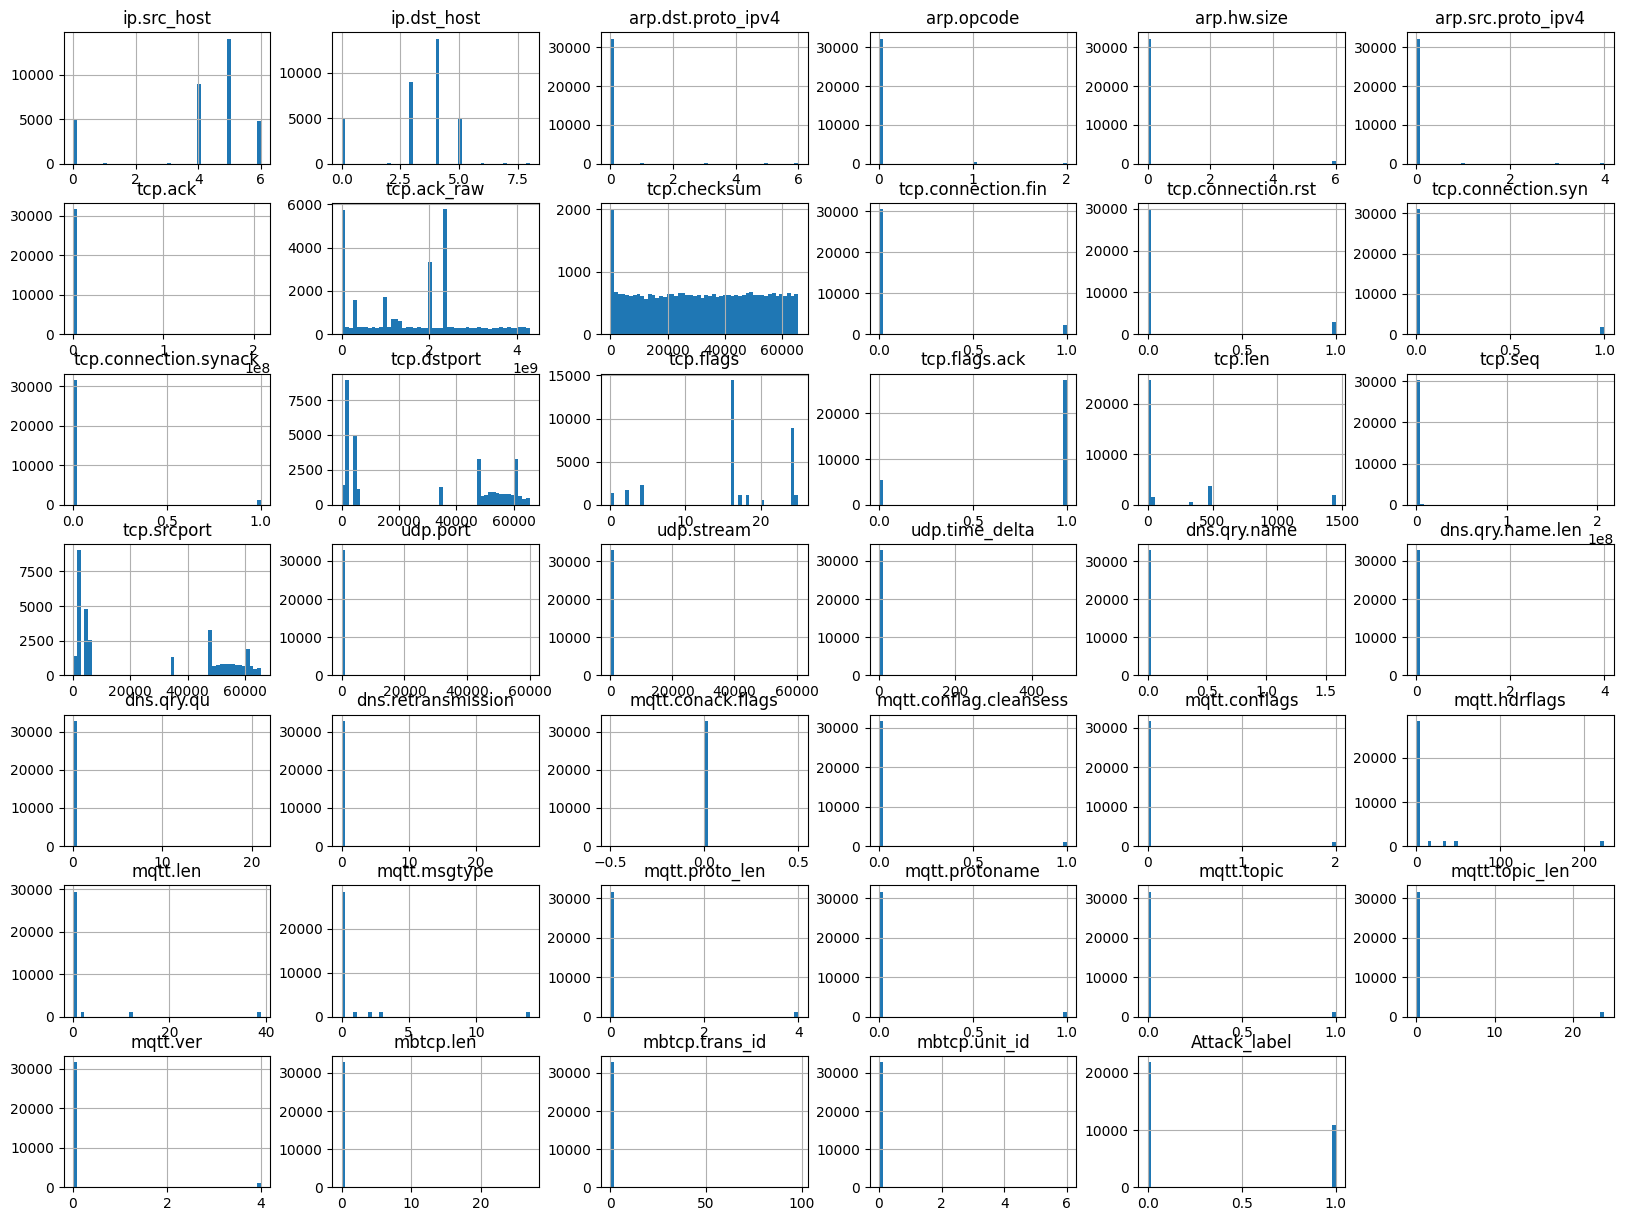

In [215]:
df_undersampled.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
df_undersampled = df_undersampled.drop(columns = 'mbtcp.len')
df_undersampled = df_undersampled.drop(columns = 'mbtcp.trans_id')
df_undersampled = df_undersampled.drop(columns = 'mbtcp.unit_id')
df_undersampled = df_undersampled.drop(columns = 'mqtt.conack.flags')
df_undersampled = df_undersampled.drop(columns = 'dns.qry.qu')
df_undersampled = df_undersampled.drop(columns = 'dns.retransmission')
print(len(df_undersampled.columns)) #35

### Correlation heatmap

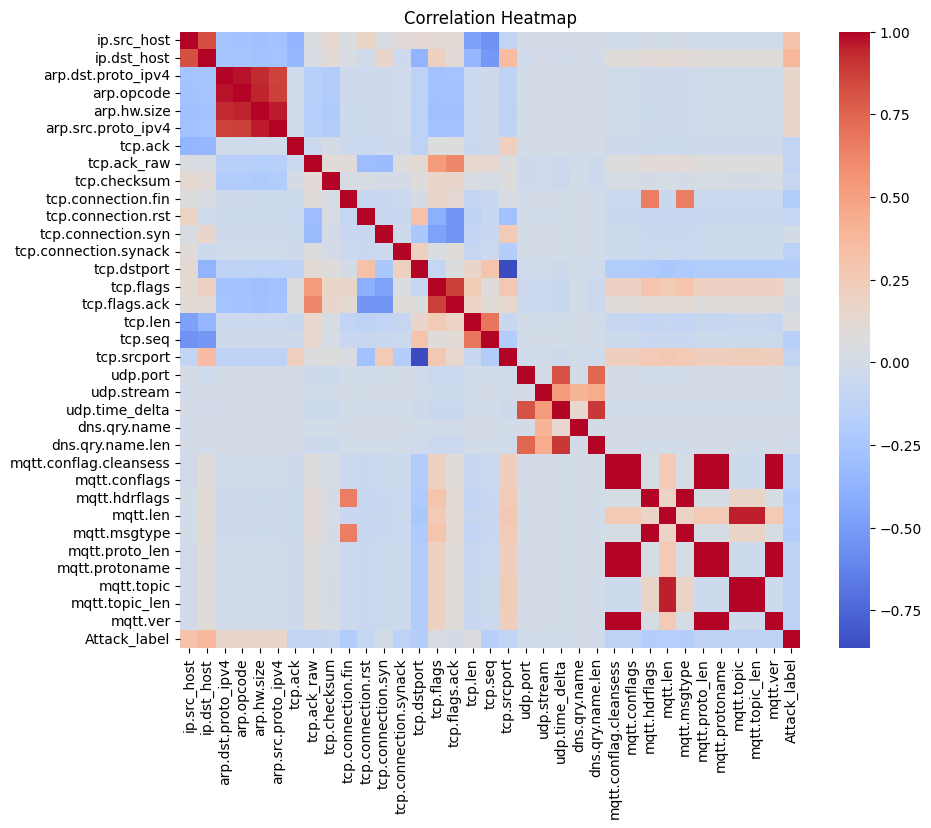

In [221]:
correlation_matrix = df_undersampled.corr()

plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
# Add labels and title
plt.title("Correlation Heatmap")
plt.show()

## Training vs test data

In [263]:
y = df_undersampled['Attack_label']
x = df_undersampled.drop(columns = 'Attack_label')

sc = MinMaxScaler()
x = sc.fit_transform(x)

# Splitting to training and test data 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state = 42)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(22942, 34) (9833, 34)
(22942,) (9833,)


In [287]:
clfr = tree.DecisionTreeClassifier()

clfr.fit(x_train, y_train)
y_test_pred_random = clfr.predict(x_test)
 
print("Train score is:", clfr.score(x_train, y_train))
print("Test score is:",clfr.score(x_test,y_test))

Train score is: 0.9969052392991021
Test score is: 0.9964405573070274


In [299]:
def alarms(cm):
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    TNR = TN / (TN + FP)
    FNR = FN / (FN + TP)

    print("#####   Alarms   ##### \n")
    print(f"True Positive Rate: {TPR:.2f}")
    print(f"False Positive Rate: {FPR:.2f}")
    
    print(f"True Negative Rate: {TNR:.2f}")
    print(f"False Negative Rate: {FNR:.2f}")

In [301]:
def confusion_mtx():
    confusion_mtx_forest = confusion_matrix(y_test_pred_random, y_test)
    print("Confusion matrix: \n{}".format(confusion_mtx_forest))
    ax = sns.heatmap(confusion_mtx_forest, annot=True, cmap='plasma', fmt='g')
    plt.show()
    confusion_mtx_forest
    ACC = classification_report(y_test_pred_random, y_test, output_dict=True)['accuracy']
    print("#####   Accuracy: {} %   ##### \n".format(ACC*100))
    print(classification_report(y_test_pred_random, y_test, output_dict=False))

    
    alarms(confusion_mtx_forest)

Confusion matrix: 
[[6521    0]
 [  35 3277]]


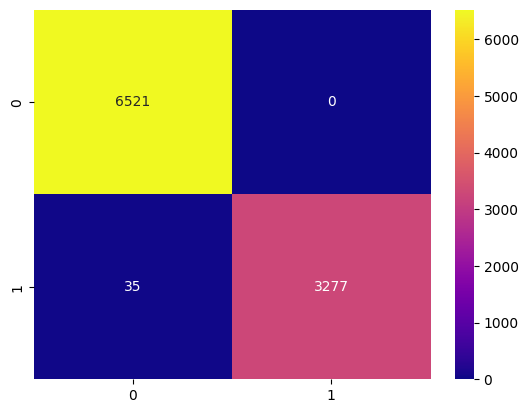

#####   Accuracy: 99.64405573070275 %   ##### 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       1.00      0.99      0.99      3312

    accuracy                           1.00      9833
   macro avg       1.00      0.99      1.00      9833
weighted avg       1.00      1.00      1.00      9833

#####   Alarms   ##### 

True Positive Rate: 0.99
False Positive Rate: 0.00
True Negative Rate: 1.00
False Negative Rate: 0.01


In [303]:
confusion_mtx()

[Text(0.717948717948718, 0.9444444444444444, 'x[1] <= 0.562\ngini = 0.444\nsamples = 22942\nvalue = [15294.0, 7648.0]'),
 Text(0.5897435897435898, 0.8333333333333334, 'x[0] <= 0.917\ngini = 0.333\nsamples = 19376\nvalue = [15283, 4093]'),
 Text(0.6538461538461539, 0.8888888888888888, 'True  '),
 Text(0.5384615384615384, 0.7222222222222222, 'x[13] <= 0.004\ngini = 0.087\nsamples = 16010\nvalue = [15283, 727]'),
 Text(0.4358974358974359, 0.6111111111111112, 'x[20] <= 0.0\ngini = 0.216\nsamples = 826\nvalue = [102, 724]'),
 Text(0.38461538461538464, 0.5, 'x[5] <= 0.375\ngini = 0.195\nsamples = 813\nvalue = [89, 724]'),
 Text(0.2564102564102564, 0.3888888888888889, 'x[2] <= 0.583\ngini = 0.302\nsamples = 470\nvalue = [87, 383]'),
 Text(0.20512820512820512, 0.2777777777777778, 'x[2] <= 0.417\ngini = 0.231\nsamples = 442\nvalue = [59, 383]'),
 Text(0.10256410256410256, 0.16666666666666666, 'x[4] <= 0.5\ngini = 0.233\nsamples = 423\nvalue = [57, 366]'),
 Text(0.05128205128205128, 0.0555555555

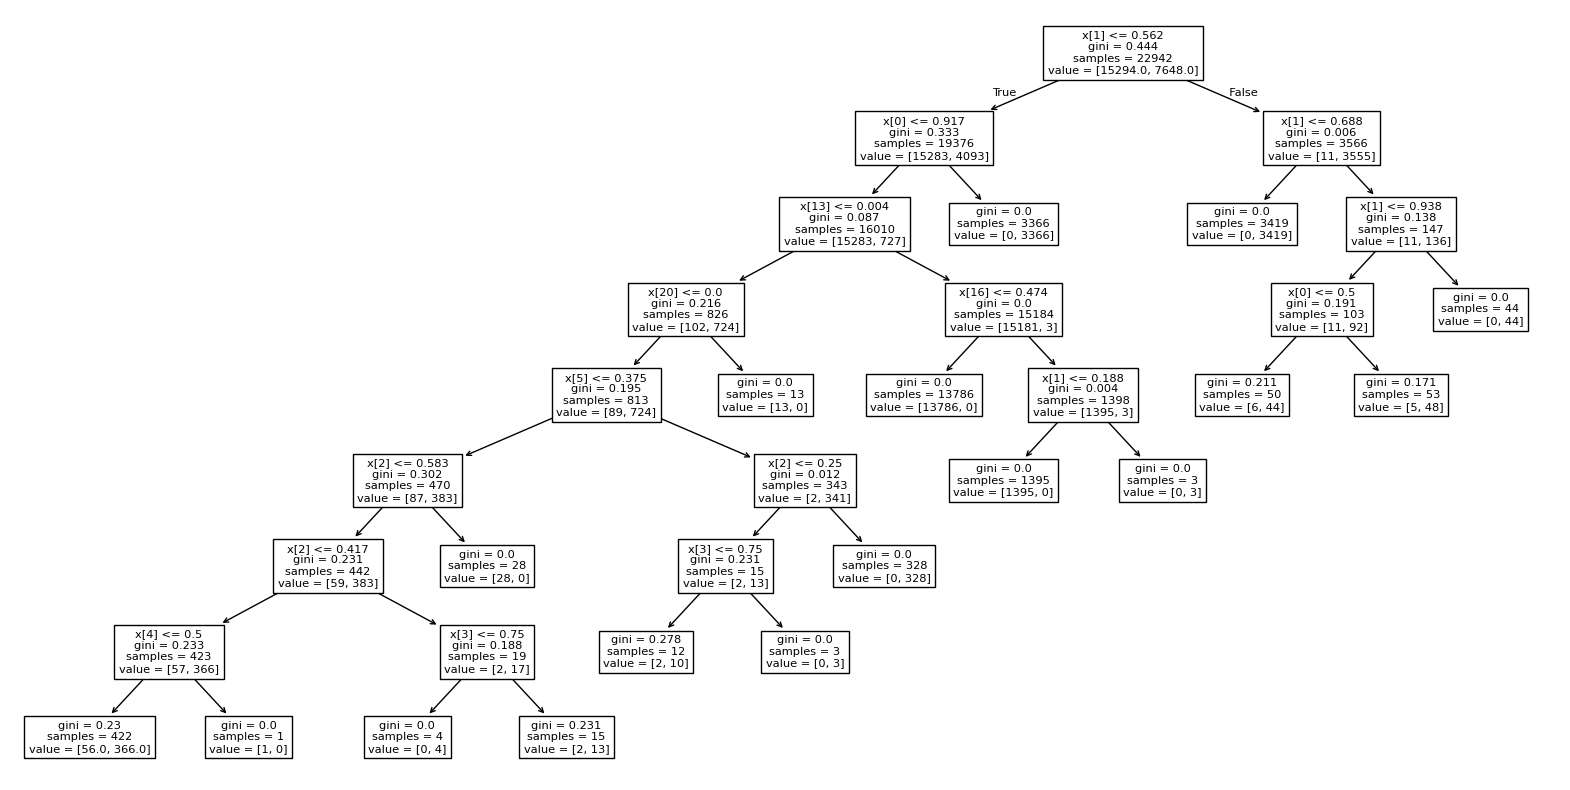

In [273]:
fig=plt.figure(figsize=(20,10))
plot_tree(clfr)

In [353]:
clf = LinearSVC()
clf.fit(x_train, y_train)
y_test_pred_random = clf.predict(x_test)
 
print("Train score is:", clfr.score(x_train, y_train))
print("Test score is:",clfr.score(x_test,y_test))

Train score is: 0.9969052392991021
Test score is: 0.9964405573070274


Confusion matrix: 
[[6517    0]
 [  39 3277]]


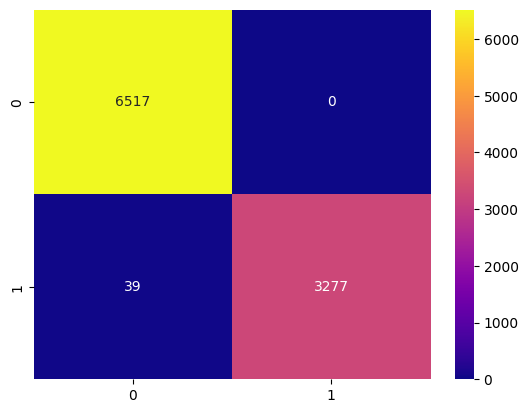

#####   Accuracy: 99.6033763856402 %   ##### 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6517
           1       1.00      0.99      0.99      3316

    accuracy                           1.00      9833
   macro avg       1.00      0.99      1.00      9833
weighted avg       1.00      1.00      1.00      9833

#####   Alarms   ##### 

True Positive Rate: 0.99
False Positive Rate: 0.00
True Negative Rate: 1.00
False Negative Rate: 0.01


In [355]:
confusion_mtx()

### Payload

In [309]:
df_payload = ransomware_df[['tcp.payload','Attack_label']]
print(df_payload.dtypes)
print(len(df_payload))

tcp.payload     object
Attack_label     int64
dtype: object
1626568


In [311]:
print(df_payload[df_payload['tcp.payload'] == '0']['Attack_label'].value_counts())
print(df_payload[df_payload['tcp.payload'] != '0']['Attack_label'].value_counts())

Attack_label
0    1090759
1       6616
Name: count, dtype: int64
Attack_label
0    524884
1      4309
Name: count, dtype: int64


In [313]:
df_payload = df_payload.drop_duplicates()
print(df_payload[df_payload['tcp.payload'] == '0']['Attack_label'].value_counts())
print(df_payload[df_payload['tcp.payload'] != '0']['Attack_label'].value_counts())

Attack_label
0    1
1    1
Name: count, dtype: int64
Attack_label
0    189177
1      4198
Name: count, dtype: int64


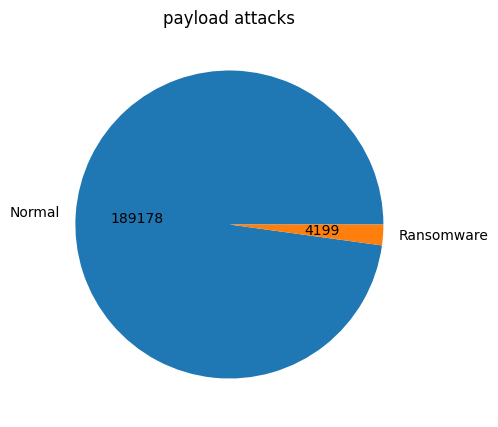

In [315]:
print_traffic_proportion_pie(df_payload, "payload attacks")

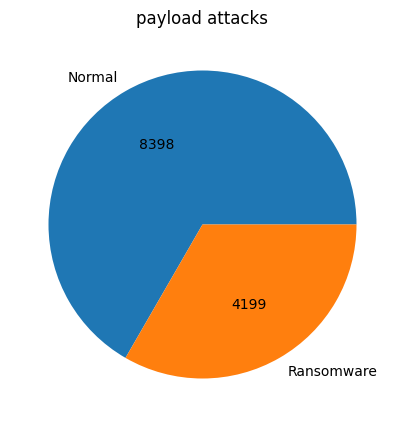

In [317]:
#undersample the Normal datasets

x = df_payload.drop(columns='Attack_label')  # Features
y = df_payload['Attack_label']  # Target
len_attack = len(df_payload[df_payload['Attack_label'] == 1])

rus = RandomUnderSampler(sampling_strategy={0: len_attack * 2}, random_state=42)

x_resampled, y_resampled = rus.fit_resample(x, y)

# Combine back into a DataFrame
df_payload = pd.concat([x_resampled, y_resampled], axis=1)
print_traffic_proportion_pie(df_payload, "payload attacks")

In [319]:
df_payload['tcp.payload'].iloc[1]

'f08df43e09b4967004de000c710a6c6634b7ad38dee8854e1c076a369d6bff304800e22909e4bff40d7977dfb03a748bbb5ca7c6963ac2d0eb8a5b0188f37f718839926018294036e773c568c20452e482e4ea227b48bb420235fa7b51329c35626b16279a05dea50a54adbbe194635dddfbde2319c6d62243d8b9d5020efe86c15be5a0197cdd7e19bf65445677729663c189803b84d998b137f0438013b60ec289899383d9bee606bcaeb7dbc1ea4561c686e4b30577f1fa3383916949ce4a305dedbd99aa7a8cffc809d0925baef5b715f705d9d790e53d8e918da543766a29d792ad7b98c24c4fd46f6df6298203de4de17abab1765db1f16b90d66f397bccca1ade32c8e36ea8c94275d51985d2a2105be8c0aedd2c000bb562283a60f7c59d63dfa574e8010953d34321b5fd7b6c32448ae32474728aee86956b98234de7e511747a43229f3b7632caed2220932c8943d7e097b9870b90e7433d285a4e7603b75cfcc10f7529c9228ce96b04a018dcbba22f5f3f8cf0105dff17838ab6c7360fe4535d6e97380ae560f5e7cc968f39145913c3db647d4f9b35852b826603211ab2610369d0ac0db6ff3a0350a3d083a1a9d300eadafee7c131c2434ab804314a5b4d046b0caa46e85030394c298ed25c80af131a87028b1a4c1dd9ab0d1b5b5cf4c4ce695e492936304c72dcbf09407f1

In [321]:
max_len_payload = int(df_payload['tcp.payload'].str.len().max()/2)
print(max_len_payload)

1448


In [323]:
strt = df_payload['tcp.payload'].iloc[1]
first_tw = ""
bytes_list = [str(df_payload['Attack_label'].iloc[1])]

In [325]:
print(len(bytes_list))

1


In [327]:
payload_columns = [f"column_{x}" for x in range(max_len_payload + 1)]
len(payload_columns)

1449

In [329]:
df_payload.iloc[0]['Attack_label']

np.int64(0)

In [331]:
with open("payload_data.csv", "w") as f:
    f.write(",".join(payload_columns) + "\n")
    for i in range(len(df_payload)):
        pl = df_payload.iloc[i]['tcp.payload']
        att = df_payload.iloc[i]['Attack_label']
            
        bytes_list = [str(att)] 
        for x in range(max_len_payload):
            if pl and pl != '0':
                first_tw = pl[:2]
                pl = pl[2:]
                bytes_list.append(first_tw)
            else:
                bytes_list.append('00')

        f.write(",".join(bytes_list) + "\n")    

In [333]:
df_bytes = pd.read_csv('payload_data.csv', low_memory=False) #load dataset

In [335]:
df_bytes.dtypes
df_bytes[:10]

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_1439,column_1440,column_1441,column_1442,column_1443,column_1444,column_1445,column_1446,column_1447,column_1448
0,0,20,00,e2,49,96,61,7a,e1,82,...,ed,3b,00,00,00,00,00,00,00,00
1,0,f0,8d,f4,3e,09,b4,96,70,04,...,a3,65,00,00,00,00,00,00,00,00
2,0,1f,64,ea,a5,d9,1f,b4,35,04,...,00,00,00,00,00,00,00,00,00,00
3,0,00,0e,1b,25,88,aa,fe,66,20,...,00,00,00,00,00,00,00,00,00,00
4,0,9f,91,5a,ec,f3,51,fe,96,f4,...,85,6a,00,00,00,00,00,00,00,00
5,0,00,0e,b3,9a,e6,44,fc,39,8e,...,00,00,00,00,00,00,00,00,00,00
6,0,18,14,ee,f6,f2,56,55,d9,bf,...,f2,67,00,00,00,00,00,00,00,00
7,0,0a,24,b1,ed,42,2a,ef,46,05,...,cd,78,00,00,00,00,00,00,00,00
8,0,8f,97,f0,31,8d,8c,22,e0,72,...,f6,54,00,00,00,00,00,00,00,00
9,0,37,9b,27,30,80,71,1f,a5,bb,...,ab,e1,00,00,00,00,00,00,00,00


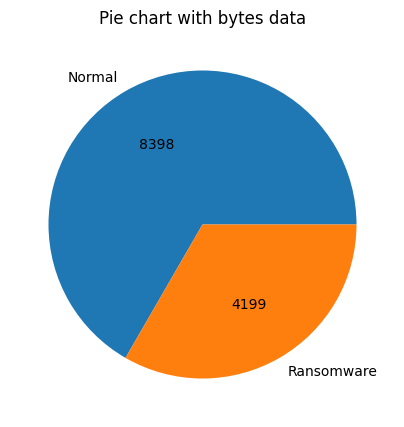

In [337]:
plt.figure(figsize=(5, 5))
plt.pie(
    x = df_bytes['column_0'].value_counts(),
    labels = ['Normal', 'Ransomware'],
    autopct = lambda p: '{:.0f}'.format(p * len(df_bytes) / 100),
)
plt.title('Pie chart with bytes data')
plt.show() 

In [339]:
# convert bytes to int
for i in range(1, df_bytes.shape[1]):
    df_bytes[f'column_{i}'] = df_bytes[f'column_{i}'].apply(lambda x: int.from_bytes(bytes.fromhex(x)))

df_bytes.dtypes

column_0       int64
column_1       int64
column_2       int64
column_3       int64
column_4       int64
               ...  
column_1444    int64
column_1445    int64
column_1446    int64
column_1447    int64
column_1448    int64
Length: 1449, dtype: object

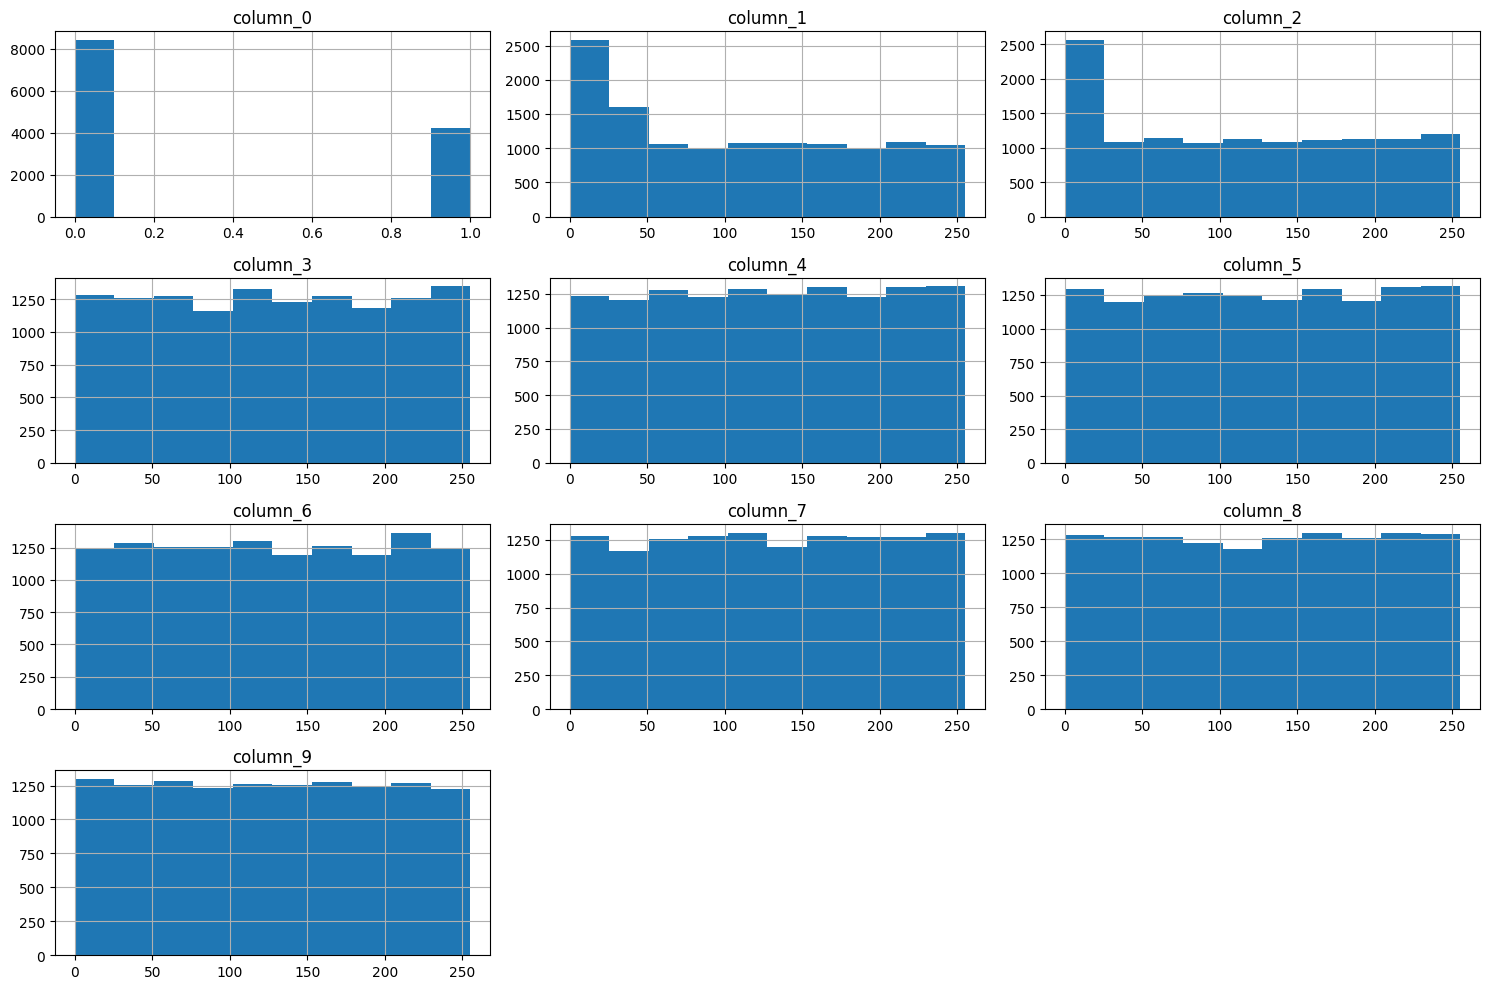

In [340]:
df_bytes.iloc[:, :10].hist(bins=10, figsize=(15, 10))
plt.tight_layout()
plt.show()

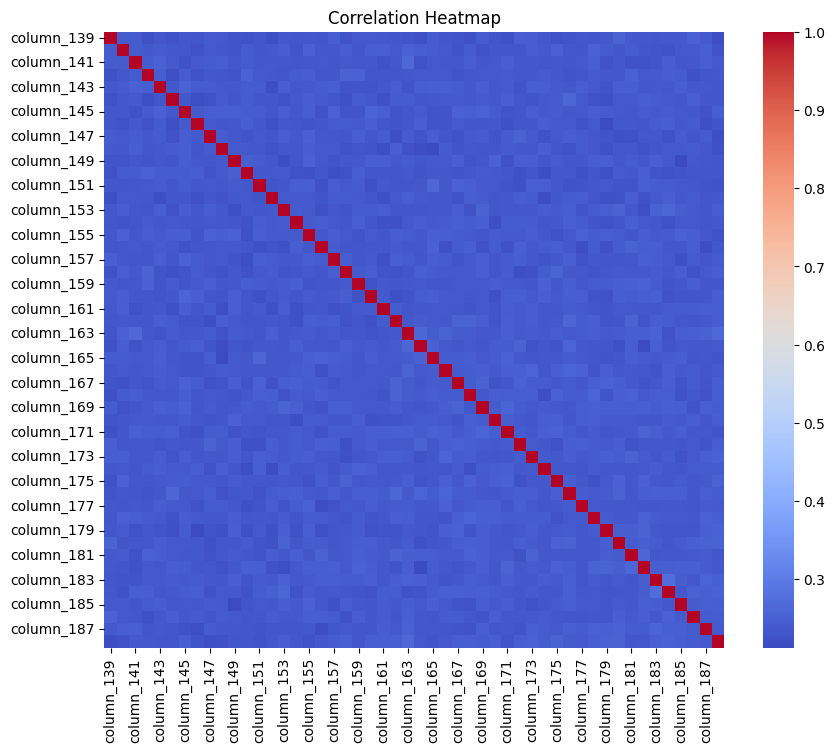

In [343]:
correlation_matrix = df_bytes.iloc[:, 139:189].corr()

plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, cmap='coolwarm')
# Add labels and title
plt.title("Correlation Heatmap")
plt.show()

<Axes: xlabel='column_182', ylabel='column_361'>

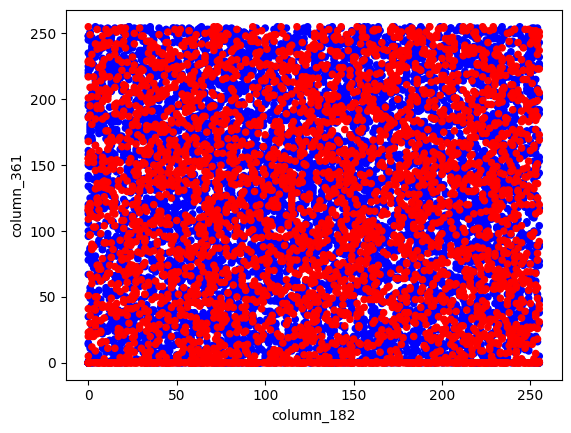

In [345]:
color_map = {0: 'blue', 1: 'red'}
colors = df_bytes['column_0'].map(color_map)
df_bytes.plot.scatter( x="column_182", y="column_361" , c=colors)

### Test data

In [455]:
y = df_bytes['column_0']
x = df_bytes.drop(columns = 'column_0')

sc = MinMaxScaler()
x = sc.fit_transform(x)

# Splitting to training and test data 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state = 42)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(17635, 1448) (7559, 1448)
(17635,) (7559,)


In [347]:
clfr =  tree.DecisionTreeClassifier()

clfr.fit(x_train, y_train)
y_test_pred_random = clfr.predict(x_test)
 
print("Train score is:", clfr.score(x_train, y_train))
print("Test score is:",clfr.score(x_test,y_test))

Train score is: 0.9969052392991021
Test score is: 0.9964405573070274


Confusion matrix: 
[[6521    0]
 [  35 3277]]


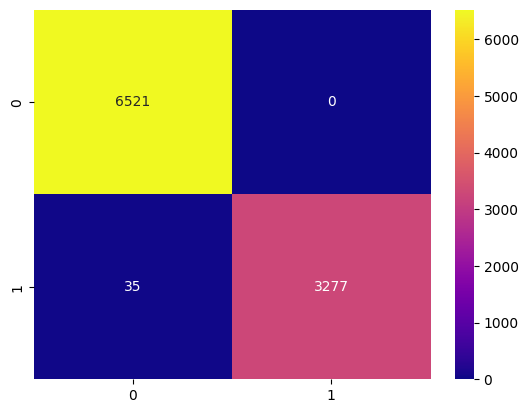

#####   Accuracy: 99.64405573070275 %   ##### 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       1.00      0.99      0.99      3312

    accuracy                           1.00      9833
   macro avg       1.00      0.99      1.00      9833
weighted avg       1.00      1.00      1.00      9833

#####   Alarms   ##### 

True Positive Rate: 0.99
False Positive Rate: 0.00
True Negative Rate: 1.00
False Negative Rate: 0.01


In [349]:
confusion_mtx()

In [357]:
clf = LinearSVC()
clf.fit(x_train, y_train)
y_test_pred_random = clf.predict(x_test)
 
print("Train score is:", clfr.score(x_train, y_train))
print("Test score is:",clfr.score(x_test,y_test))

Train score is: 0.9969052392991021
Test score is: 0.9964405573070274


Confusion matrix: 
[[6517    0]
 [  39 3277]]


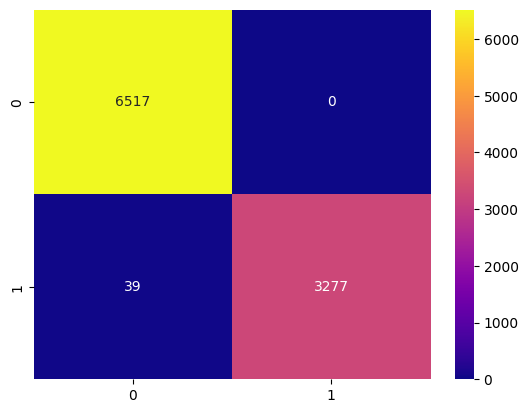

#####   Accuracy: 99.6033763856402 %   ##### 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6517
           1       1.00      0.99      0.99      3316

    accuracy                           1.00      9833
   macro avg       1.00      0.99      1.00      9833
weighted avg       1.00      1.00      1.00      9833

#####   Alarms   ##### 

True Positive Rate: 0.99
False Positive Rate: 0.00
True Negative Rate: 1.00
False Negative Rate: 0.01


In [359]:
confusion_mtx()